# Caching for Reinforcement Learning

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def zipf(VN, n, a=1):
    p = np.array([1/(i**a) for i in range(1,VN+1)])
    p = p / sum(p)
    c = np.random.choice([i for i in range(VN)], n, False, p)
    C = [0] * VN
    for c in c:
        C[c] = 1
    return np.array(C)

def choice(q, n):
    p = q / sum(q)
    c = np.array([0] * len(p))
    while sum(c) < n:
        m = np.amax(p)
        idx = np.random.choice(np.where(p == m)[0])
        if c[idx] == 0:
            c[idx] = 1
            p[idx] = min(p)
    return np.array([c])

class cache_env:
    def __init__(self, VN, cs, a=1):
        self.VN = VN
        self.cs = cs
        self.a = a
        self.state = choice(np.array([1]*self.VN), self.cs)
    
    def step(self, cache_action):
        self.state = cache_action
        self.request = zipf(self.VN, 1, self.a)
        reward = self.state * self.request
        return reward

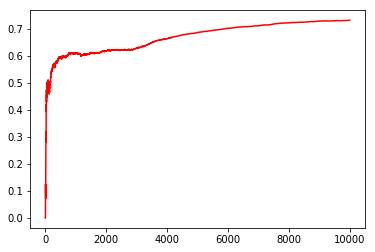

Final caching list : [0, 1, 2, 4, 12]
Test hit rate : 0.862


In [2]:
number_of_video = 100
cache_size = 5
cache = cache_env(number_of_video, cache_size, 2)

input_size = len(cache.state[0])
output_size = input_size
learning_rate = 0.01
dis = 0.9

X = tf.placeholder(shape=[1, input_size], dtype = tf.float32)
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01))

Qpred = tf.matmul(X, W)
Y = tf.placeholder(shape=[1, output_size], dtype = tf.float32)
loss = tf.reduce_sum(tf.square(Y - Qpred))

train = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

N = 10000
t = [n for n in range(N)]
train_r = 0
train_hit = []
test_r = 0

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(N):
        e = 0.1
        Qs = sess.run(Qpred, feed_dict = {X:cache.state})
        
        if np.random.rand(1) < e:
            a = choice(np.array([1]*number_of_video), cache_size)  # 액션 정하기
        else:
            a = choice(Qs[0], cache_size)
        
        reward = cache.step(a)  # 액션 수행
        Qs[0] = reward + dis * Qs[0]
        sess.run(train, feed_dict = {X:cache.state, Y:Qs})  # 업데이트 된 것으로 학습 시키기
        
        train_r += sum(reward[0])
        train_hit.append(train_r/(i+1))
    
    for _ in range(1000):
        a = choice(Qs[0], cache_size)
        reward = cache.step(a)
        test_r += sum(reward[0])
    test_r /= 1000

max_list = []
for _ in range(cache_size):
    max_list.append(np.argmax(Qs[0]))
    Qs[0][np.argmax(Qs[0])] = np.min(Qs[0])
max_list.sort()
    
plt.plot(t,train_hit,'r')
plt.show()
print('Final caching list :', max_list)
print('Test hit rate :', test_r)

# Only one cache replacement

# RL

In [1]:
M = 10
N = 50
number_of_video = 20
number_of_client = 1
cache_size = 3

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def zipf(VN, N, P, n, a=1):
    p = np.array([1/(i**a) for i in range(1,VN+1)])
    p = p / sum(p)
    C = np.zeros((N, VN))
    for i in range(N):
        c = np.random.choice([i for i in range(VN)], n, False, p)
        for c in c:
            C[i][P[i][c]] = 1
    return np.array(C)

def choice(q, cs):
    N, VN = q.shape
    C = np.zeros((N, VN))
    for i in range(N):
        p = q[i] / sum(q[i])
        c = C[i]
        while sum(c) < cs:
            m = np.amax(p)
            idx = np.random.choice(np.where(p == m)[0])
            if c[idx] == 0:
                c[idx] = 1
                p[idx] = min(p)
    return C

class cache_env:
    def __init__(self, VN, N, P, cs, a=1):
        self.VN = VN
        self.N = N
        self.cs = cs
        self.a = a
        self.P = P
        self.state = choice(np.ones((N, VN)), self.cs)
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
    
    def action(self, a):
        for i in range(len(a)):
            idx = np.where(self.state[i]==1)[0]
            try:
                self.state[i][idx[np.where(a[i]==1)[0][0]]] = 0
            except:
                continue
            self.state[i] += self.request[i]
    
    def step(self, cache_action):
        self.action(cache_action)
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
        reward = np.zeros((self.N,1))
        for i in range(self.N):
            while sum(self.state[i] * self.request[i]) == 1:
                self.request[i] = zipf(self.VN, 1, self.P, 1, self.a)[0]
                reward[i] += 1
        return reward

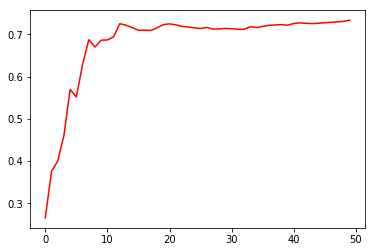

In [3]:
train_hit_M = np.zeros(N)
for _ in range(M):
    action_state = cache_size + 1
    # P = np.array([np.random.permutation([i for i in range(number_of_video)]) for _ in range(number_of_client)]) # Random Preference
    P = np.array([np.array([i for i in range(number_of_video)]) for _ in range(number_of_client)])
    cache = cache_env(number_of_video, number_of_client, P, cache_size, 2)

    learning_rate = 0.01
    dis = 0.9

    X = tf.placeholder(shape=[number_of_client, number_of_video * 2], dtype = tf.float32)
    W = tf.Variable(tf.random_uniform([number_of_video * 2, action_state], 0, 0.01))

    Qpred = tf.matmul(X, W)
    Y = tf.placeholder(shape=[number_of_client, action_state], dtype = tf.float32)
    loss = tf.reduce_sum(tf.square(Y - Qpred))

    train = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

    t = [n for n in range(N)]
    train_r = 0
    train_count = 0
    train_hit = []

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for i in range(N):
            e = 1/(i/10+1) + 0.01
            Qs = sess.run(Qpred, feed_dict = {X:np.hstack((cache.request,cache.state))})

            if np.random.rand(1) < e:
                a = np.identity(action_state)[np.random.choice(range(action_state), number_of_client)]  # 액션 정하기
            else:
                a = np.identity(action_state)[np.argmax(Qs, 1)]    

            reward = a * cache.step(a)  # 액션 수행
            Qs1 = sess.run(Qpred, feed_dict = {X:np.hstack((cache.request,cache.state))})
            Qs = reward + dis * np.max(Qs1) * np.identity(action_state)[np.argmax(Qs1)]
            sess.run(train, feed_dict = {X:np.hstack((cache.request,cache.state)), Y:Qs})  # 업데이트 된 것으로 학습 시키기

            train_r += np.sum(reward) / number_of_client
            train_count += np.sum(reward) / number_of_client + number_of_client
            train_hit.append(train_r/train_count)
        train_hit_M += np.array(train_hit)

plt.plot(t,train_hit_M / M,'r')
plt.show()

# FIFO

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_list(n):
    l = [[]]
    for _ in range(n-1):
        l += [[]]
    return l

def zipf(VN, N, P, n, a=1):
    p = np.array([1/(i**a) for i in range(1,VN+1)])
    p = p / sum(p)
    C = make_list(N)
    for i in range(N):
        c = np.random.choice([i for i in range(VN)], n, False, p)
        for c in c:
            C[i].append(P[i][c])
    return list(C)

def choice(q, cs):
    N, VN = q.shape
    C = make_list(N)
    for i in range(N):
        p = q[i] / sum(q[i])
        c = C[i]
        while len(c) < cs:
            m = np.amax(p)
            idx = np.random.choice(np.where(p == m)[0])
            c.append(idx)
            p[idx] = min(p)
    return list(C)

class cache_env:
    def __init__(self, VN, N, P, cs, a=1):
        self.VN = VN
        self.N = N
        self.cs = cs
        self.a = a
        self.P = P
        self.state = make_list(N)
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
    
    def step(self):
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
        reward = np.zeros((self.N,1))
        for i in range(self.N):
            while self.request[i][0] in self.state[i]:
                self.request[i] = zipf(self.VN, 1, self.P, 1, self.a)[0]
                reward[i] += 1
        self.replacement()
        return np.sum(reward)
    
    def replacement(self):
        for i in range(self.N):
            if len(self.state[i]) < self.cs:
                self.state[i].append(self.request[i][0])
            else:
                self.state[i] = self.state[i][1:] + self.request[i]

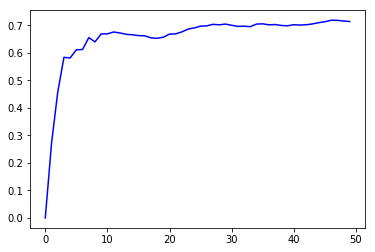

In [13]:
FIFO_hit_M = np.zeros(N)
for _ in range(M):
    P = np.array([np.random.permutation([i for i in range(number_of_video)]) for _ in range(number_of_client)]) # Random Preference
    # P = np.array([np.array([i for i in range(number_of_video)]) for _ in range(number_of_client)])
    cache = cache_env(number_of_video, number_of_client, P, cache_size, 2)

    t = [n for n in range(N)]
    FIFO_r = 0
    FIFO_count = 0
    FIFO_hit = []

    for i in range(N):
        reward = cache.step()
        FIFO_r += reward
        FIFO_count += reward + number_of_client
        FIFO_hit.append(FIFO_r / FIFO_count)
    FIFO_hit_M += np.array(FIFO_hit)

plt.plot(t,FIFO_hit_M / M,'b')
plt.show()

# LFU

In [14]:
class cache_env:
    def __init__(self, VN, N, P, cs, a=1):
        self.VN = VN
        self.N = N
        self.cs = cs
        self.a = a
        self.P = P
        self.state = make_list(N)
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
        self.rq_count = [0] * VN
    
    def step(self):
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
        reward = np.zeros((self.N,1))
        for i in range(self.N):
            while self.request[i][0] in self.state[i]:
                self.request[i] = zipf(self.VN, 1, self.P, 1, self.a)[0]
                self.rq_count[self.request[i][0]] += 1
                reward[i] += 1
        self.replacement()
        return np.sum(reward)
    
    def replacement(self):
        def count(i):
            return self.rq_count[i]
        for i in range(self.N):
            if len(self.state[i]) < self.cs:
                self.state[i].append(self.request[i][0])
            else:
                count_l = list(map(count, self.state[i]))
                idx = np.where(np.array(count_l) == min(count_l))[0]
                self.state[i].remove(self.state[i][idx[0]])
                self.state[i].append(self.request[i][0])

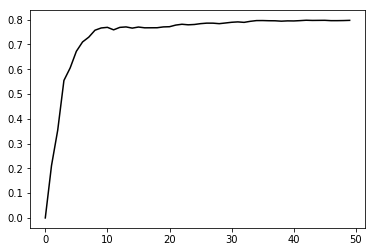

In [15]:
LFU_hit_M = np.zeros(N)
for _ in range(M):
    P = np.array([np.random.permutation([i for i in range(number_of_video)]) for _ in range(number_of_client)]) # Random Preference
    # P = np.array([np.array([i for i in range(number_of_video)]) for _ in range(number_of_client)])
    cache = cache_env(number_of_video, number_of_client, P, cache_size, 2)

    t = [n for n in range(N)]
    LFU_r = 0
    LFU_count = 0
    LFU_hit = []

    for i in range(N):
        reward = cache.step()
        LFU_r += reward
        LFU_count += reward + number_of_client
        LFU_hit.append(LFU_r / LFU_count)
    LFU_hit_M += np.array(LFU_hit)
        
plt.plot(t,LFU_hit_M / M,'k')
plt.show()

# LRU

In [16]:
class cache_env:
    def __init__(self, VN, N, P, cs, a=1):
        self.VN = VN
        self.N = N
        self.cs = cs
        self.a = a
        self.P = P
        self.state = make_list(N)
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
    
    def step(self):
        self.request = zipf(self.VN, self.N, self.P, 1, self.a)
        reward = np.zeros((self.N,1))
        for i in range(self.N):
            while self.request[i][0] in self.state[i]:
                self.replacement()
                self.request[i] = zipf(self.VN, 1, self.P, 1, self.a)[0]
                reward[i] += 1
        self.replacement()
        return np.sum(reward)
    
    def replacement(self):
        for i in range(self.N):
            if self.request[i] in self.state[i]:
                if len(self.state[i]) < self.cs:
                    continue
                else:
                    self.state[i].remove(self.request[i])
                    self.state[i].append(self.request[i][0])
            else:
                if len(self.state[i]) < self.cs:
                    self.state[i].append(self.request[i][0])
                else:
                    self.state[i] = self.state[i][1:] + self.request[i]

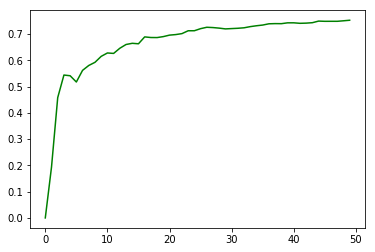

In [17]:
LRU_hit_M = np.zeros(N)
for _ in range(M):
    P = np.array([np.random.permutation([i for i in range(number_of_video)]) for _ in range(number_of_client)]) # Random Preference
    # P = np.array([np.array([i for i in range(number_of_video)]) for _ in range(number_of_client)])
    cache = cache_env(number_of_video, number_of_client, P, cache_size, 2)

    t = [n for n in range(N)]
    LRU_r = 0
    LRU_count = 0
    LRU_hit = []

    for i in range(N):
        reward = cache.step()
        LRU_r += reward
        LRU_count += reward + number_of_client
        LRU_hit.append(LRU_r / LRU_count)
    LRU_hit_M += np.array(LRU_hit)

plt.plot(t,LRU_hit_M / M,'g')
plt.show()

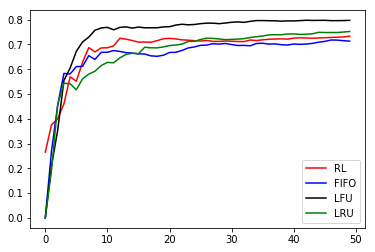

In [18]:
plt.plot(t,train_hit_M / M,'red')
plt.plot(t,FIFO_hit_M / M,'blue')
plt.plot(t,LFU_hit_M / M,'black')
plt.plot(t,LRU_hit_M / M,'green')
plt.legend(['RL', 'FIFO', 'LFU', 'LRU'])
plt.show()